In [1]:
import numpy as np 
import glob
import cv2
import random
import matplotlib.pyplot as plt

### For I4,I5,I6

ratio_for_matching = 0.75
idx = 0
threshold_for_inliers = 100
threshold_for_inliers_distance = 5
trials = 1000


### For I3
ratio_for_matching = 0.5
idx = 2
threshold_for_inliers = 100
threshold_for_inliers_distance = 10
trials = 10000


### For I2
ratio_for_matching = 0.5
idx = 0
threshold_for_inliers = 100
threshold_for_inliers_distance = 10
trials = 1000


### For I1

ratio_for_matching = 0.4
idx = 0
threshold_for_inliers = 100
threshold_for_inliers_distance = 5
trials = 10000

In [2]:
ratio_for_matching = 0.4
idx = 0
# threshold_for_inliers = 100
threshold_for_inliers_distance = 5
trials = 10000

In [3]:
image_directories = glob.glob("../../Images/*")
image_paths = [sorted(glob.glob(image_directory+'/*')) for image_directory in image_directories]
image_paths[idx]

['../../Images\\I1\\STA_0031.JPG',
 '../../Images\\I1\\STB_0032.JPG',
 '../../Images\\I1\\STC_0033.JPG',
 '../../Images\\I1\\STD_0034.JPG',
 '../../Images\\I1\\STE_0035.JPG',
 '../../Images\\I1\\STF_0036.JPG']

In [4]:
num_images = len(image_paths[idx])
num_images

6

In [5]:
mid_image = num_images//2
mid_img = cv2.imread(image_paths[idx][mid_image])

left_img = cv2.imread(image_paths[idx][mid_image-1])
right_img = cv2.imread(image_paths[idx][mid_image+1])


# Find the keypoints in left and mid image

In [6]:
sift = cv2.SIFT_create()
left_gray_img = cv2.cvtColor(left_img, cv2.COLOR_BGR2GRAY)
mid_gray_img = cv2.cvtColor(mid_img, cv2.COLOR_BGR2GRAY)
right_gray_img = cv2.cvtColor(right_img, cv2.COLOR_BGR2GRAY)
kp1, des1 = sift.detectAndCompute(left_img,None)
kp2, des2 = sift.detectAndCompute(mid_img,None)
kp3, des3 = sift.detectAndCompute(right_img,None)

In [7]:
len(des1), len(des2), len(des3)

(37954, 26381, 20593)

In [8]:
def matching(des1, des2, ratio_for_matching):
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1,des2, k=2)
    print('Total matches before ratio test: ',len(matches)) # number of descriptors in left image is 37954 and number of matches is also 37954, 
                                                            # which means for every descriptor in left image we get k descriptors from right image
    mapped = []
    for m,n in matches:
        if m.distance < ratio_for_matching*n.distance: # Here we check if distance to the best match (m) is significantly smaller than the distance to the second-best match (n)
            mapped.append([m])
    print('Total matches after ratio test: ',len(mapped))
    return matches, mapped

In [9]:
matches, mapped = matching(des1, des2, ratio_for_matching)

Total matches before ratio test:  37954
Total matches after ratio test:  436


In [10]:
len(matches) # number of descriptors in left image is 37954 and number of matches is also 37954, whhich means for every descriptor in left image we get k descriptors from right image

37954

# matches have attributes ['distance', 'imgIdx', 'queryIdx', 'trainIdx']

DMatch.distance - Distance between descriptors. The lower, the better it is.

DMatch.trainIdx - Index of the descriptor in train descriptors

DMatch.queryIdx - Index of the descriptor in query descriptors

DMatch.imgIdx - Index of the train image.

In [11]:
matches[0][0].distance,  matches[0][0].trainIdx, matches[0][0].queryIdx, matches[0][0].imgIdx # queryIdx is the left image and train_idx is the right image

(343.8909606933594, 21986, 0, 0)

In [12]:
matches[0][1].distance, matches[0][1].trainIdx, matches[0][1].queryIdx, matches[0][1].imgIdx

(345.0072326660156, 2392, 0, 0)

In [13]:
matches[1][0].distance,  matches[1][0].trainIdx, matches[1][0].queryIdx, matches[1][0].imgIdx

(308.0746765136719, 12268, 1, 0)

In [14]:
matches[1][1].distance,  matches[1][1].trainIdx, matches[1][1].queryIdx, matches[1][1].imgIdx

(310.6219482421875, 8081, 1, 0)

In [15]:
len(mapped) # number of matches after applying ratio test

436

In [16]:
img = cv2.drawMatchesKnn(left_img, kp1, mid_img, kp2, mapped[:100], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
cv2.imwrite('shataxi_keypoints_matching.png', img)

True

# Find Homography matrix

In [17]:
for m in mapped:
    # print(dir(m[0]))
    # print(dir(kp1[m[0].queryIdx]))
    print(f'queryIdx (left image) {kp1[m[0].queryIdx].pt}')
    print(f'trainIdx (right image) {kp2[m[0].trainIdx].pt}')
    kp1[m[0].queryIdx]
    kp2[m[0].trainIdx]
    break

if len(mapped) > 4:
    print('\n Enough matches')

queryIdx (left image) (1582.974365234375, 290.8915710449219)
trainIdx (right image) (123.45454406738281, 306.5572204589844)

 Enough matches


In [18]:
def homography(A):
    A = np.array(A)
    _, _, Vtranspose = np.linalg.svd(A)
    H = Vtranspose[-1].reshape(3,3)
    H = H / H[-1][-1]
    return H

# RANSAC

In [19]:
def ransac(mapped, kp1, kp2):
    random.seed(0)
    best_inliers = []
    best_H = None
    for i in range(trials):
        A = []
        random_matches = random.choices(mapped, k = 4)
        for m in random_matches:
            xs, ys = kp1[m[0].queryIdx].pt
            xd, yd = kp2[m[0].trainIdx].pt
            A.append([xs, ys, 1, 0, 0, 0, -xd*xs, -xd*ys, -xd])
            A.append([0, 0, 0, xs, ys, 1, -yd*xs, -yd*ys, -yd])
            
        H = homography(A) # Homography matrix for converting from xs, ys to xd, yd
        # print(H)
        inliers = []
        for m in mapped:
            xs, ys = kp1[m[0].queryIdx].pt
            xd, yd = kp2[m[0].trainIdx].pt
            xd_hat, yd_hat, _ = np.dot(H, [xs, ys, 1])
            diff = np.linalg.norm(np.array([xd, yd]) - np.array([xd_hat, yd_hat]))
            if diff < threshold_for_inliers_distance:
                inliers.append(m)

        if len(inliers) > len(best_inliers):
            best_inliers = inliers
            best_H = H
    return best_H, best_inliers

In [20]:
best_Hl, best_inliers = ransac(mapped, kp1, kp2)

if best_Hl is not None:
    print('Homography matrix')
    print(best_Hl)
    print(f'Number of inliers: {len(best_inliers)}')

Homography matrix
[[ 1.11449310e+00 -3.05579960e-02 -2.00014610e+03]
 [ 2.71264374e-02  1.04624025e+00 -1.12037575e+02]
 [-7.99162517e-06  1.59803157e-05  1.00000000e+00]]
Number of inliers: 145


# Check whether the inliers are good or not

In [21]:
tmp = cv2.drawMatchesKnn(left_img, kp1, mid_img, kp2, best_inliers, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
cv2.imwrite('shataxi_keypoints_matching_inliers.png', tmp)


True

# find the homography using cv2.findhomography

In [22]:
def cv2_homography(best_inliers, kp1, kp2):
    src_pts = np.float32([ kp1[m[0].queryIdx].pt for m in best_inliers ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m[0].trainIdx].pt for m in best_inliers ]).reshape(-1,1,2)

    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    return M

Ml = cv2_homography(best_inliers, kp1, kp2)
Ml

array([[ 9.49378103e-01, -3.58396812e-02, -1.69256826e+03],
       [-5.00872842e-02,  9.35679515e-01,  2.50735323e+01],
       [-7.57051917e-05,  2.02527293e-05,  1.00000000e+00]])

In [23]:
def show_warped_images(left_gray_img, canvas_size, M, best_H, direction):
    fig, ax = plt.subplots(1,2, figsize=(20,10))
    tmp = cv2.warpPerspective(left_gray_img, M, (canvas_size[0], canvas_size[1]))
    tmp = cv2.cvtColor(tmp, cv2.COLOR_GRAY2BGR)
    ax[0].imshow(tmp)
    ax[0].set_title(f'{direction} image warped to mid image by opencv homography matrix')

    tmp = cv2.warpPerspective(left_gray_img, best_H, (canvas_size[0], canvas_size[1]))
    tmp = cv2.cvtColor(tmp, cv2.COLOR_GRAY2BGR)
    ax[1].imshow(tmp)
    ax[1].set_title(f'{direction} image warped to mid image by custom homography matrix')

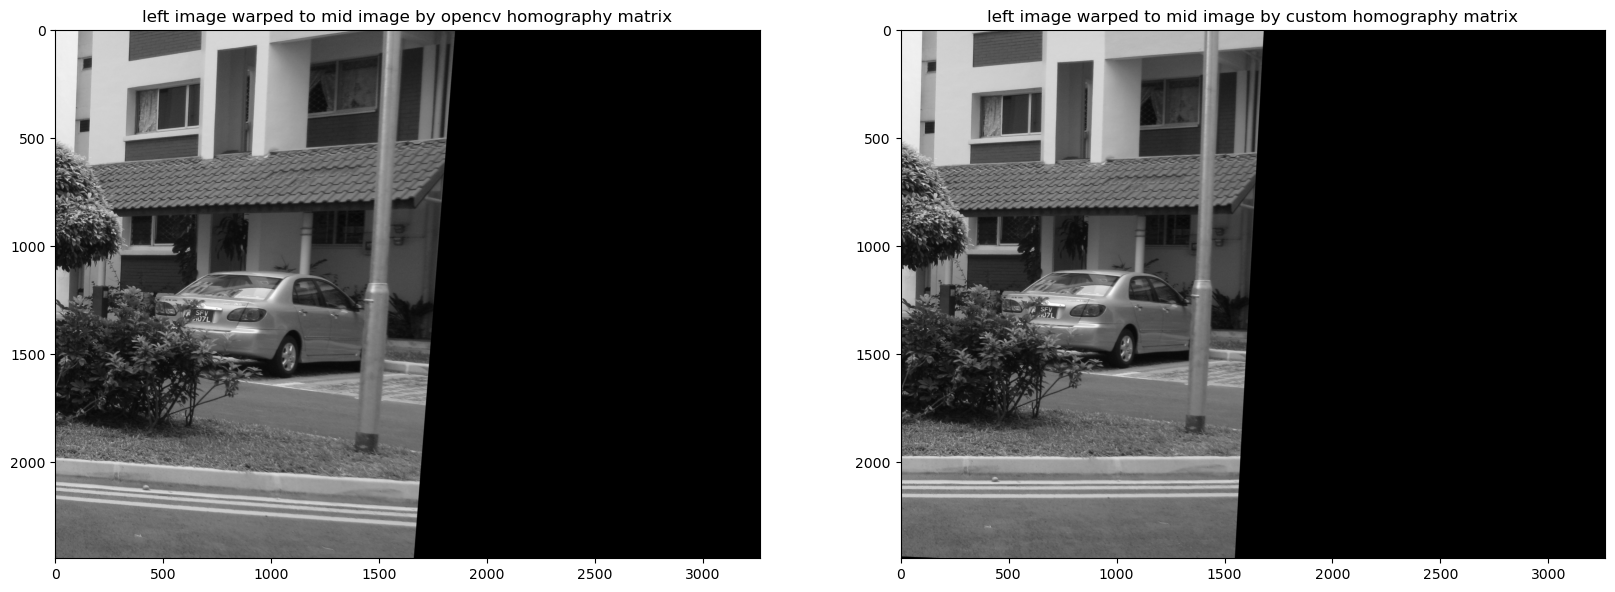

In [25]:
canvas_size = (mid_gray_img.shape[1], mid_gray_img.shape[0])
show_warped_images(left_gray_img, canvas_size, Ml, best_Hl, 'left')


# Get the src img (left img) warped

In [26]:
def warped_coords(img, best_H):
    xdyd = []

    # top left
    xd, yd, _ = np.dot(best_H, np.array([0, 0, 1]))
    xdyd.append([xd, yd])

    # top right
    xs, ys = img.shape[1], img.shape[0]
    xd, yd, _ = np.dot(best_H, np.array([xs, 0, 1]))
    xdyd.append([xd, yd])

    # bottom right
    xs, ys = img.shape[1], img.shape[0]
    xd, yd, _ = np.dot(best_H, np.array([xs, ys, 1]))
    xdyd.append([xd, yd])

    # bottom left
    xs, ys = img.shape[1], img.shape[0]
    xd, yd, _ = np.dot(best_H, np.array([0, ys, 1]))
    xdyd.append([xd, yd])
    
    return xdyd

In [27]:
# draws two subplots
def coordinates_view(xdyd, xdyd1, mid_gray_img):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].plot([0, mid_gray_img.shape[1], mid_gray_img.shape[1], 0, 0], [0, 0, mid_gray_img.shape[0], mid_gray_img.shape[0], 0], 'r-', label='reference img')
    ax[0].plot([xdyd1[0][0], xdyd1[1][0], xdyd1[2][0], xdyd1[3][0], xdyd1[0][0]], [xdyd1[0][1], xdyd1[1][1], xdyd1[2][1], xdyd1[3][1], xdyd1[0][1]], 'b-', label='warped img')
    ax[0].set_title('Homography computed by cv2.findHomography')
    ax[0].legend()

    ax[1].plot([0, mid_gray_img.shape[1], mid_gray_img.shape[1], 0, 0], [0, 0, mid_gray_img.shape[0], mid_gray_img.shape[0], 0], 'r-', label='reference img')
    ax[1].plot([xdyd[0][0], xdyd[1][0], xdyd[2][0], xdyd[3][0], xdyd[0][0]], [xdyd[0][1], xdyd[1][1], xdyd[2][1], xdyd[3][1], xdyd[0][1]], 'b-', label='warped img')
    ax[1].set_title('Homography computed by hand')
    ax[1].legend()

In [28]:
xdyd = warped_coords(left_gray_img, best_Hl)
xdyd1 = warped_coords(left_gray_img, Ml)

In [29]:
[[0,0], [mid_gray_img.shape[1], 0], [mid_gray_img.shape[1], mid_gray_img.shape[0]], [0, mid_gray_img.shape[0]]]

[[0, 0], [3264, 0], [3264, 2448], [0, 2448]]

In [30]:
xdyd, xdyd1

([[-2000.1461035653751, -112.03757516719017],
  [1637.559378090818, -23.496883498589924],
  [1562.7534037981886, 2537.6992390808114],
  [-2074.9520778580045, 2449.158547412211]],
 [[-1692.5682628190173, 25.073532340564984],
  [1406.2018650649754, -138.411363217656],
  [1318.4663255178414, 2152.1320885974023],
  [-1780.3038023661513, 2315.6169841556234]])

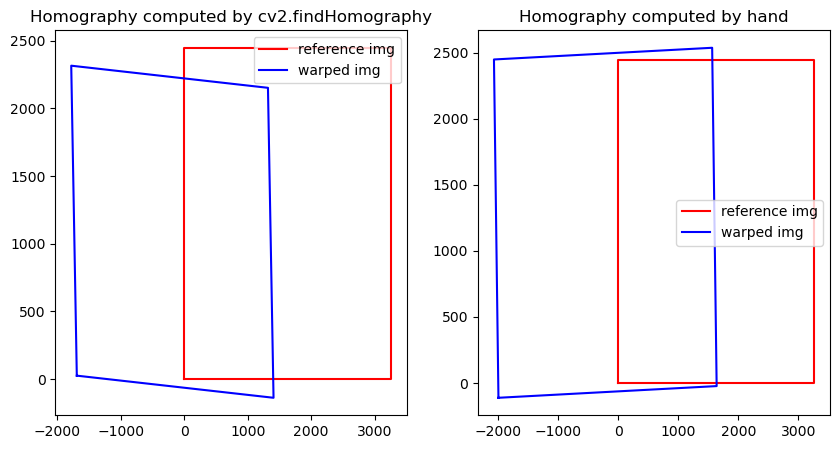

In [31]:
coordinates_view(xdyd, xdyd1, mid_gray_img)

# Working on Right image and mid image

In [32]:
# bf = cv2.BFMatcher()
# matches = bf.knnMatch(des3,des2,k=2)

matches, mapped = matching(des3, des2, ratio_for_matching)
len(matches), len(des2), len(des3), len(kp2), len(kp3)

Total matches before ratio test:  20593
Total matches after ratio test:  1126


(20593, 26381, 20593, 26381, 20593)

In [33]:
img = cv2.drawMatchesKnn(right_img, kp3, mid_img, kp2, mapped[:100], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
cv2.imwrite('shataxi_keypoints_matching.png', img)

True

In [34]:
best_Hr, best_inliers = ransac(mapped, kp3, kp2)

if best_Hr is not None:
    print('Homography matrix')
    print(best_Hr)
    print(f'Number of inliers: {len(best_inliers)}')

Homography matrix
[[ 1.00475107e+00 -5.96643126e-03  1.38444435e+03]
 [ 1.23231981e-02  9.92289995e-01  4.15679135e+01]
 [ 4.21405016e-06 -4.46527428e-06  1.00000000e+00]]
Number of inliers: 578


check whether the inliers are good or not

In [35]:
tmp = cv2.drawMatchesKnn(right_img, kp3, mid_img, kp2, best_inliers, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
cv2.imwrite('shataxi_keypoints_matching_inliers.png', tmp)

True

find homography using cv2.findHomography

In [36]:
src_pts = np.float32([ kp3[m[0].queryIdx].pt for m in best_inliers ]).reshape(-1,1,2)
dst_pts = np.float32([ kp2[m[0].trainIdx].pt for m in best_inliers ]).reshape(-1,1,2)

Mr, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
Mr

array([[ 9.39574057e-01, -7.96056998e-03,  1.40380607e+03],
       [-6.34479054e-03,  9.78317289e-01,  5.53123941e+01],
       [-1.90256835e-05,  2.14999204e-07,  1.00000000e+00]])

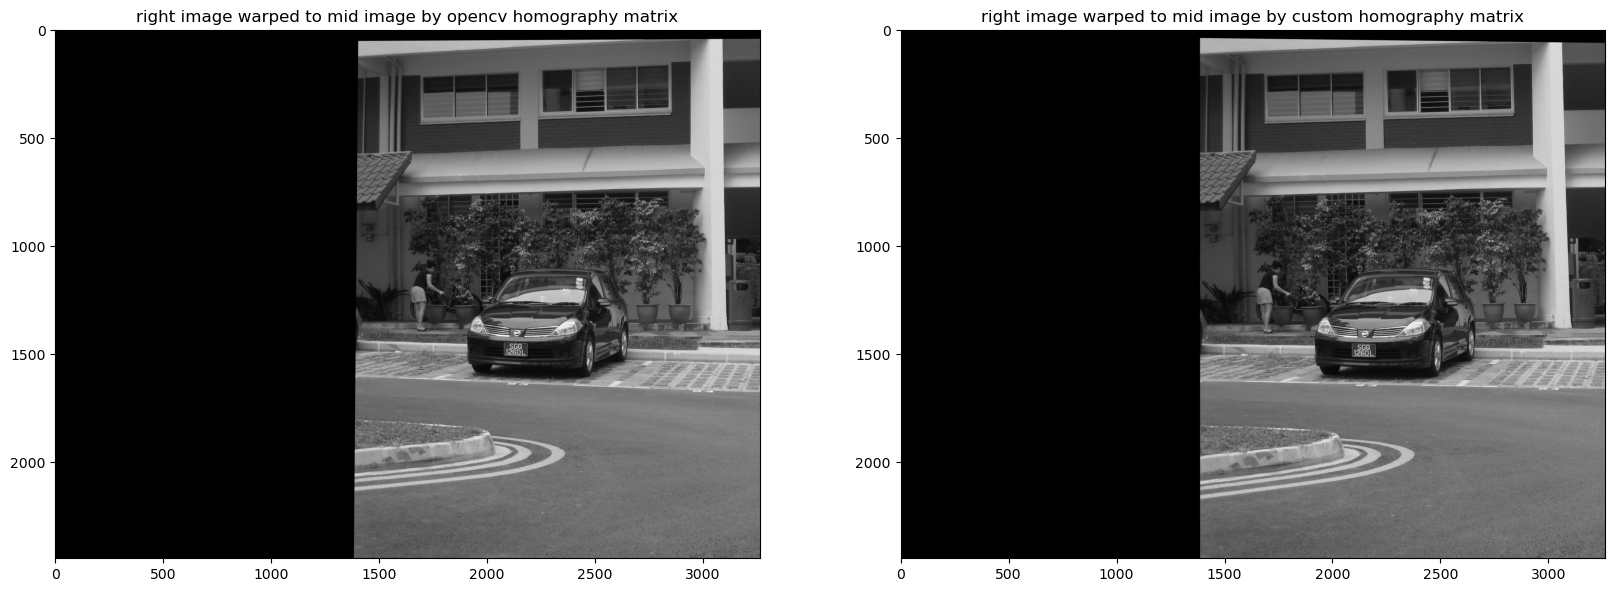

In [37]:
canvas_size = (mid_gray_img.shape[1], mid_gray_img.shape[0])
show_warped_images(right_gray_img, canvas_size, Mr, best_Hr, 'right')


In [38]:
xdyd_r = warped_coords(right_img, best_Hr)
xdyd_r1 = warped_coords(right_img, Mr)

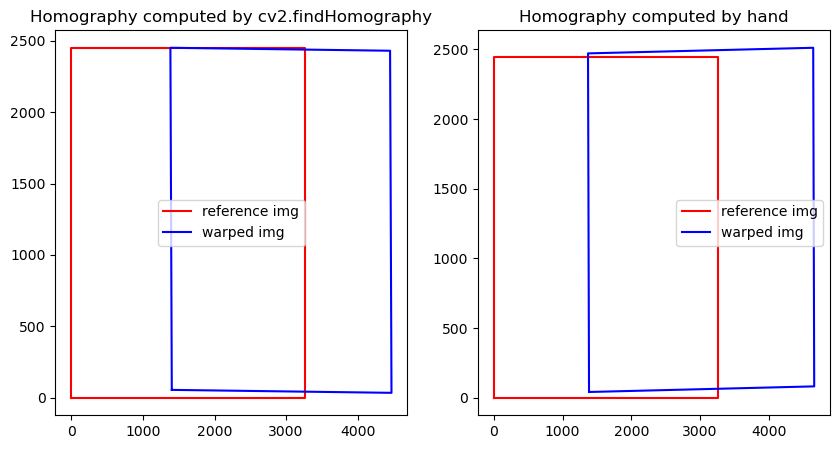

In [39]:
coordinates_view(xdyd_r, xdyd_r1, mid_gray_img)

# canvas size containing right image and reference image

In [40]:
tmp = np.concatenate([xdyd_r, np.array([[0,0],[mid_img.shape[1], 0], [mid_img.shape[1], mid_img.shape[0]], [0, mid_img.shape[0]]])], axis = 0)
xmax, xmin = np.max(tmp[:,0]), np.min(tmp[:,0])
ymax, ymin = np.max(tmp[:, 1]), np.min(tmp[:,1])
print(xmax, xmin,ymax, ymin)
canvas_size = (int(xmax-xmin), int(ymax-ymin))
canvas_size

4663.951835129905 0.0 2510.916739789646 0.0


(4663, 2510)

# Stitching mid and right image using warpperspective

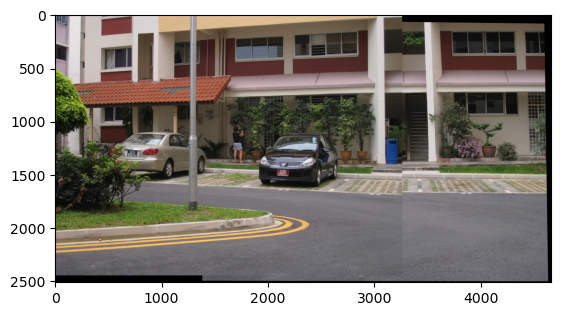

In [41]:
tmp = cv2.warpPerspective(right_img, best_Hr, canvas_size)
tmp[0:mid_img.shape[0], 0:mid_img.shape[1], :] = mid_img
tmp = cv2.cvtColor(tmp, cv2.COLOR_BGR2RGB)
plt.imshow(tmp)

# Stitching mid and right image from scratch

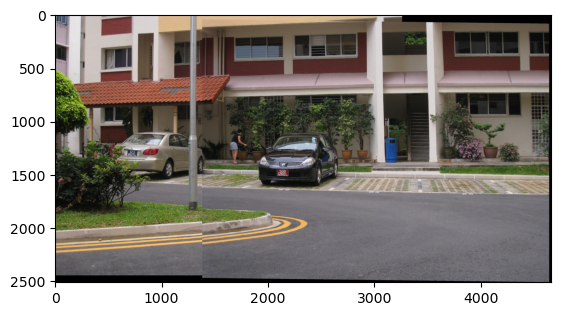

In [42]:
big_img = np.zeros((canvas_size[1], canvas_size[0], 3), dtype=np.uint8) # row1 - p1,p2,p3,p4......pn, row2 - p1,p2,p3,p4......pn, row3 - p1,p2,p3,p4......pn
big_img[0:mid_img.shape[0], 0:mid_img.shape[1], :] = mid_img

best_Hinv = np.linalg.inv(best_Hr)
for x in range(canvas_size[0]):
    for y in range(canvas_size[1]):
        dx, dy, _ = np.dot(best_Hinv, np.array([x, y, 1]))
        dx, dy = int(dx), int(dy)
        if dx >= 0 and dx < right_img.shape[1] and dy >= 0 and dy < right_img.shape[0]:
            big_img[y, x, :] = right_img[dy, dx, :]

plt.imshow(cv2.cvtColor(big_img, cv2.COLOR_BGR2RGB))

# canvas size containing left image and reference image

In [43]:
tmp = np.concatenate([xdyd, np.array([[0,0],[mid_img.shape[1], 0], [mid_img.shape[1], mid_img.shape[0]], [0, mid_img.shape[0]]])], axis = 0)
xmax, xmin = np.max(tmp[:,0]), np.min(tmp[:,0])
ymax, ymin = np.max(tmp[:, 1]), np.min(tmp[:,1])
offsetx = abs(int(xmin))
offsety = abs(int(ymin))
print(xmax, xmin,ymax, ymin, offsetx, offsety)
canvas_size = (int(xmax-xmin), int(ymax-ymin))
canvas_size

3264.0 -2074.9520778580045 2537.6992390808114 -112.03757516719017 2074 112


(5338, 2649)

# stitching left image and reference image using warp perspective

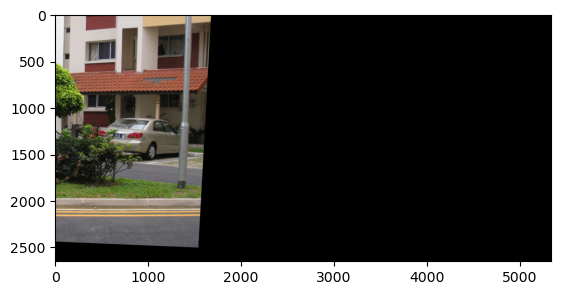

In [44]:
tmp = cv2.warpPerspective(left_img, best_Hl, canvas_size) # here we can see the negative coordinates are not covered in canvas so we need to translate the coordinates
plt.imshow(cv2.cvtColor(tmp, cv2.COLOR_BGR2RGB))

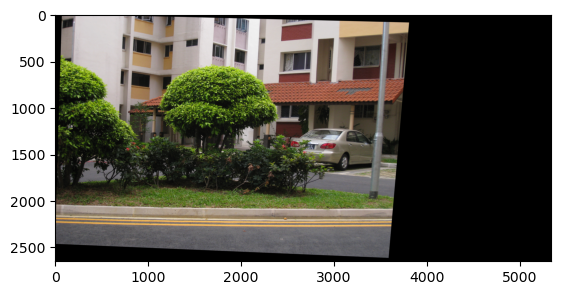

In [45]:
# translate the coordinates
best_Hl_translated = best_Hl.copy()
best_Hl_translated[0][2] += offsetx
best_Hl_translated[1][2] += offsety

tmp = cv2.warpPerspective(left_img, best_Hl_translated, canvas_size) # now the negative coordinates are brought into canvas
plt.imshow(cv2.cvtColor(tmp, cv2.COLOR_BGR2RGB))

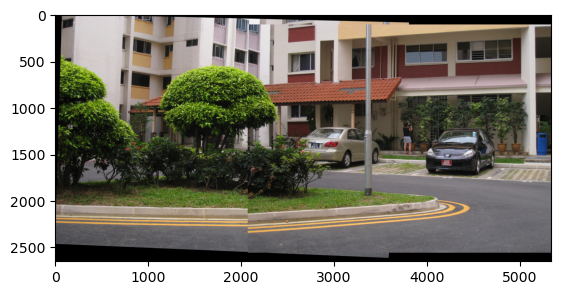

In [46]:
tmp[0+offsety:mid_img.shape[0]+offsety, 0+offsetx:mid_img.shape[1]+offsetx, :] = mid_img
plt.imshow(cv2.cvtColor(tmp, cv2.COLOR_BGR2RGB))

# stitching left and reference image from scratch

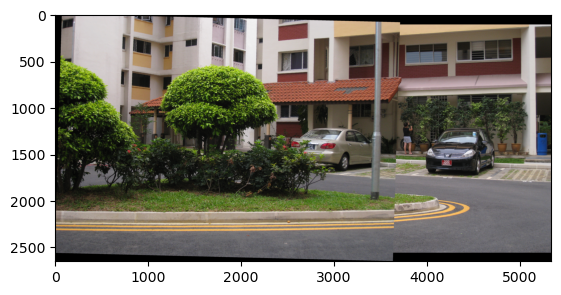

In [47]:
big_img = np.zeros((canvas_size[1], canvas_size[0], 3), dtype=np.uint8) # row1 - p1,p2,p3,p4......pn, row2 - p1,p2,p3,p4......pn, row3 - p1,p2,p3,p4......pn

best_Hlinv = np.linalg.inv(best_Hl_translated) # remember to use the translated homography matrix to accomodate the negative coordinates
# big_img[0+offsety : mid_img.shape[0]+offsety, 0+offsetx : mid_img.shape[1]+offsetx, :] = mid_img
for x in range(canvas_size[0]):
    for y in range(canvas_size[1]):
        dx, dy, _ = np.dot(best_Hlinv, np.array([x, y, 1]))
        dx, dy = int(dx), int(dy)
        if dx >= 0 and dx < left_img.shape[1] and dy >= 0 and dy < left_img.shape[0]:
            big_img[y, x, :] = left_img[dy, dx, :]
            
for y in range(offsety, mid_img.shape[0]+offsety):
    for x in range(offsetx, mid_img.shape[1]+offsetx):
        if np.all(big_img[y, x, :] == [0,0,0]):
            big_img[y, x, :] = mid_img[y-offsety, x-offsetx, :]


plt.imshow(cv2.cvtColor(big_img, cv2.COLOR_BGR2RGB))

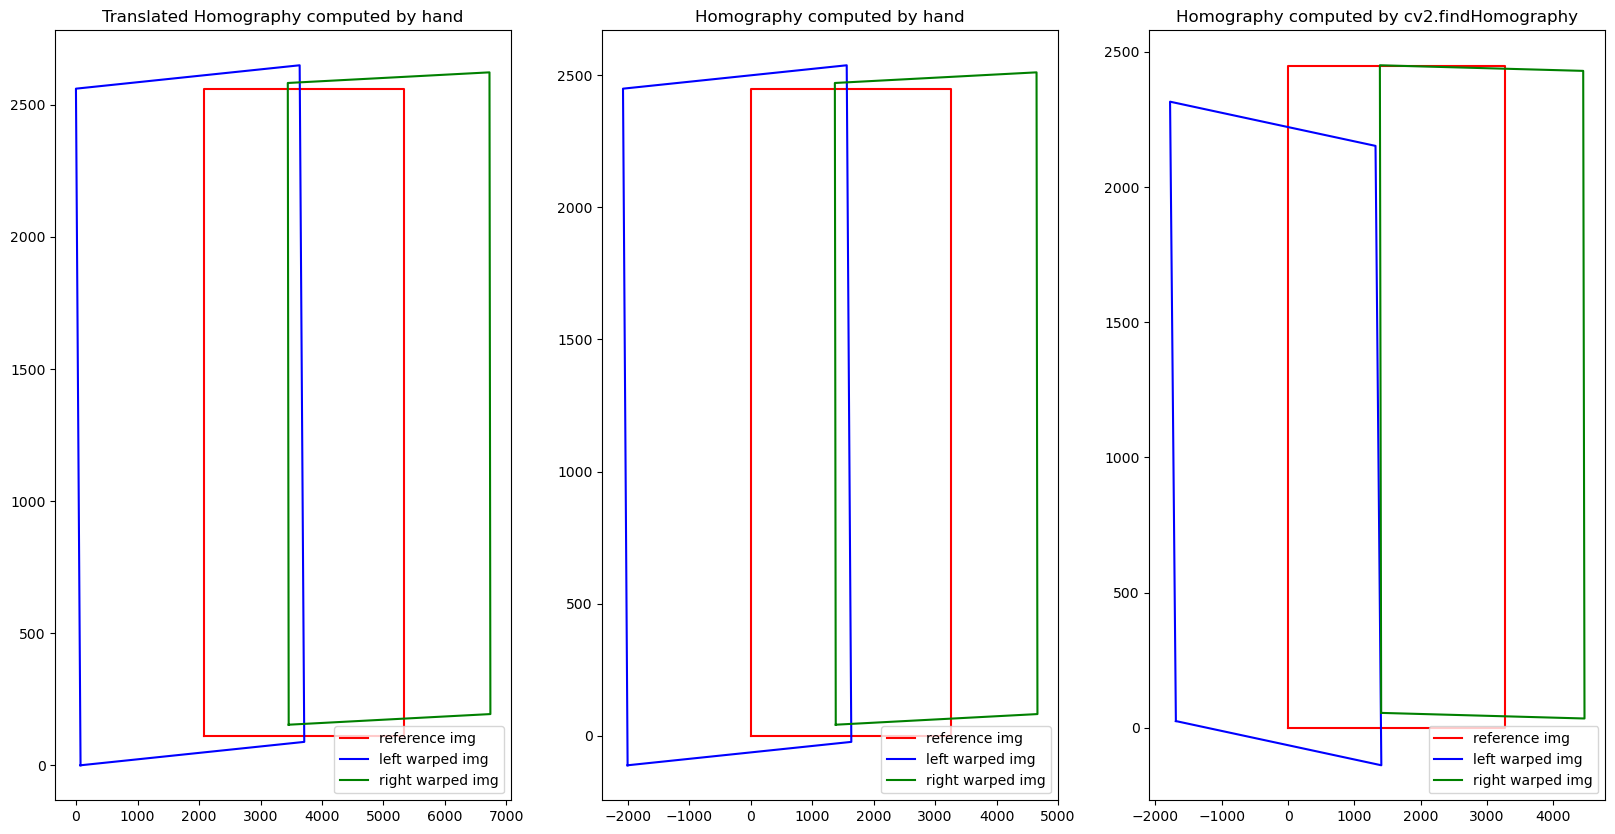

In [48]:
fig, ax = plt.subplots(1,3, figsize=(20,10))
ax[0].plot([0+offsetx, mid_img.shape[1]+offsetx, mid_img.shape[1]+offsetx, 0+offsetx, 0+offsetx], [0+offsety, 0+offsety, mid_img.shape[0]+offsety, mid_img.shape[0]+offsety, 0+offsety], 'r-', label='reference img')
ax[0].plot([xdyd[0][0]+offsetx, xdyd[1][0]+offsetx, xdyd[2][0]+offsetx, xdyd[3][0]+offsetx, xdyd[0][0]+offsetx], [xdyd[0][1]+offsety, xdyd[1][1]+offsety, xdyd[2][1]+offsety, xdyd[3][1]+offsety, xdyd[0][1]+offsety], 'b-', label='left warped img')
ax[0].plot([xdyd_r[0][0]+offsetx, xdyd_r[1][0]+offsetx, xdyd_r[2][0]+offsetx, xdyd_r[3][0]+offsetx, xdyd_r[0][0]+offsetx], [xdyd_r[0][1]+offsety, xdyd_r[1][1]+offsety, xdyd_r[2][1]+offsety, xdyd_r[3][1]+offsety, xdyd_r[0][1]+offsety], 'g-', label='right warped img')
ax[0].set_title('Translated Homography computed by hand')
ax[0].legend()

ax[1].plot([0, mid_img.shape[1], mid_img.shape[1], 0, 0], [0, 0, mid_img.shape[0], mid_img.shape[0], 0], 'r-', label='reference img')
ax[1].plot([xdyd[0][0], xdyd[1][0], xdyd[2][0], xdyd[3][0], xdyd[0][0]], [xdyd[0][1], xdyd[1][1], xdyd[2][1], xdyd[3][1], xdyd[0][1]], 'b-', label='left warped img')
ax[1].plot([xdyd_r[0][0], xdyd_r[1][0], xdyd_r[2][0], xdyd_r[3][0], xdyd_r[0][0]], [xdyd_r[0][1], xdyd_r[1][1], xdyd_r[2][1], xdyd_r[3][1], xdyd_r[0][1]], 'g-', label='right warped img')
ax[1].set_title('Homography computed by hand')
ax[1].legend()

ax[2].plot([0, mid_img.shape[1], mid_img.shape[1], 0, 0], [0, 0, mid_img.shape[0], mid_img.shape[0], 0], 'r-', label='reference img')
ax[2].plot([xdyd1[0][0], xdyd1[1][0], xdyd1[2][0], xdyd1[3][0], xdyd1[0][0]], [xdyd1[0][1], xdyd1[1][1], xdyd1[2][1], xdyd1[3][1], xdyd1[0][1]], 'b-', label='left warped img')
ax[2].plot([xdyd_r1[0][0], xdyd_r1[1][0], xdyd_r1[2][0], xdyd_r1[3][0], xdyd_r1[0][0]], [xdyd_r1[0][1], xdyd_r1[1][1], xdyd_r1[2][1], xdyd_r1[3][1], xdyd_r1[0][1]], 'g-', label='right warped img')
ax[2].set_title('Homography computed by cv2.findHomography')
ax[2].legend()


# stitching left, reference and right using warp perspective

In [49]:
xdyd_r = np.array(xdyd_r)
xdyd_r[:,0] += offsetx
xdyd_r[:,1] += offsety
tmp = np.concatenate([xdyd_r, np.array([[0,0],[big_img.shape[1], 0], [big_img.shape[1], big_img.shape[0]], [0, big_img.shape[0]]])], axis = 0)
xmax, xmin = np.max(tmp[:,0]), np.min(tmp[:,0])
ymax, ymin = np.max(tmp[:, 1]), np.min(tmp[:,1])
print(xmax, xmin,ymax, ymin)
canvas_size = (int(xmax-xmin), int(ymax-ymin))
canvas_size

6737.951835129905 0.0 2649.0 0.0


(6737, 2649)

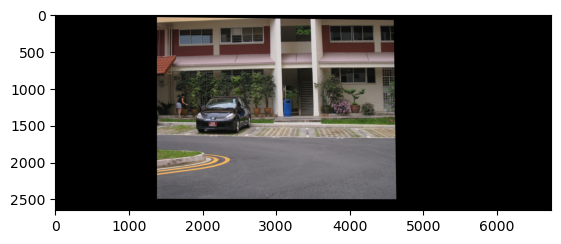

In [50]:
tmp = cv2.warpPerspective(right_img, best_Hr, canvas_size) # Here we can see the right image is positioned with the assumption that reference image is at center
plt.imshow(cv2.cvtColor(tmp, cv2.COLOR_BGR2RGB))

In [51]:
# translate the best_Hr because the reference image is now stitched with left and reference image is also translated

best_Hr_translated = best_Hr.copy()
best_Hr_translated[0][2] += offsetx
best_Hr_translated[1][2] += offsety

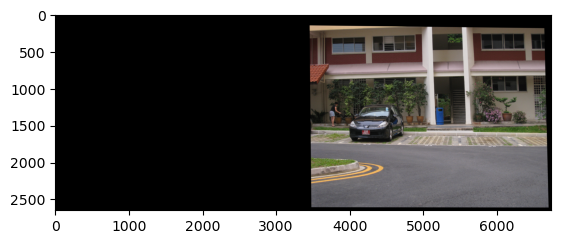

In [52]:
tmp = cv2.warpPerspective(right_img, best_Hr_translated, canvas_size) # here we can see that the right image is positioned correctly
plt.imshow(cv2.cvtColor(tmp, cv2.COLOR_BGR2RGB))

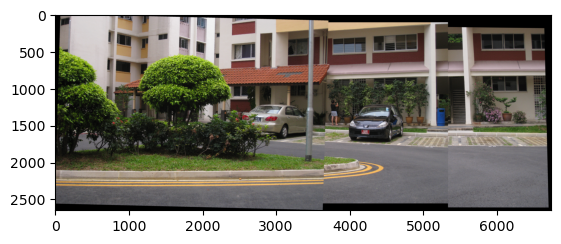

In [53]:
tmp[0:big_img.shape[0], 0:big_img.shape[1], :] = big_img
plt.imshow(cv2.cvtColor(tmp, cv2.COLOR_BGR2RGB))

# stitching left, reference and right from scratch

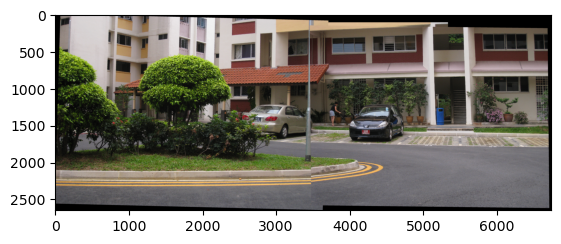

In [54]:
final_img = np.zeros((canvas_size[1], canvas_size[0], 3), dtype=np.uint8) # row1 - p1,p2,p3,p4......pn, row2 - p1,p2,p3,p4......pn, row3 - p1,p2,p3,p4......pn

best_Hrinv = np.linalg.inv(best_Hr_translated) # remember to use the translated homography matrix to accomodate the negative coordinates

for x in range(canvas_size[0]):
    for y in range(canvas_size[1]):
        dx, dy, _ = np.dot(best_Hrinv, np.array([x, y, 1]))
        dx, dy = int(dx), int(dy)
        if dx >= 0 and dx < right_img.shape[1] and dy >= 0 and dy < right_img.shape[0]:
            final_img[y, x, :] = right_img[dy, dx, :]

# final_img[0 : big_img.shape[0], 0: big_img.shape[1], :] = big_img
for y in range(big_img.shape[0]):
    for x in range(big_img.shape[1]):
        if np.all(big_img[y, x]) != 0 and np.all(final_img[y,x]) == 0:
            final_img[y,x] = big_img[y,x]

plt.imshow(cv2.cvtColor(final_img, cv2.COLOR_BGR2RGB))

In [55]:
print(mid_image)

second_img = cv2.imread(image_paths[idx][mid_image-2])
second_gray_img = cv2.cvtColor(second_img, cv2.COLOR_BGR2GRAY)

kp0, des0 = sift.detectAndCompute(second_img,None)
print(len(des0), len(des1), len(kp0), len(kp1))

matches, mapped = matching(des0, des1, ratio_for_matching)

3
32500 37954 32500 37954
Total matches before ratio test:  32500
Total matches after ratio test:  485


In [56]:
best_Hl12, best_inliers = ransac(mapped, kp0, kp1)

In [57]:
if best_Hl12 is not None:
    print('Homography matrix')
    print(best_Hl12)
    print(f'Number of inliers: {len(best_inliers)}')

Homography matrix
[[ 1.09022322e+00 -7.80589762e-02 -1.81332396e+03]
 [ 5.03924219e-02  1.04189113e+00 -1.70578397e+02]
 [ 1.28540118e-06 -6.68778868e-06  1.00000000e+00]]
Number of inliers: 136


In [58]:
xdyd12 = warped_coords(second_gray_img, best_Hl12)

tmp = np.concatenate([xdyd12, np.array([[0,0],[final_img.shape[1], 0], [final_img.shape[1], final_img.shape[0]], [0, final_img.shape[0]]])], axis = 0)
xmax, xmin = np.max(tmp[:,0]), np.min(tmp[:,0])
ymax, ymin = np.max(tmp[:, 1]), np.min(tmp[:,1])
offsetx = abs(int(xmin))
offsety = abs(int(ymin))
print(xmax, xmin,ymax, ymin, offsetx, offsety)
canvas_size = (int(xmax-xmin), int(ymax-ymin))
canvas_size

6737.0 -2004.412329728598 2649.0 -170.5783966399408 2004 170


(8741, 2819)

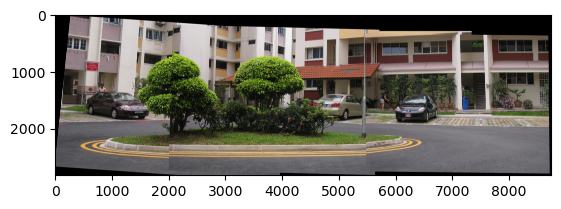

In [ ]:
# translate the coordinates
best_Hl12_translated = best_Hl12.copy()
best_Hl12_translated[0][2] += offsetx
best_Hl12_translated[1][2] += offsety

# tmp = cv2.warpPerspective(second_img, best_Hl12_translated, canvas_size) # now the negative coordinates are brought into canvas
# plt.imshow(cv2.cvtColor(tmp, cv2.COLOR_BGR2RGB))

big_img1234 = np.zeros((canvas_size[1], canvas_size[0], 3), dtype=np.uint8) # row1 - p1,p2,p3,p4......pn, row2 - p1,p2,p3,p4......pn, row3 - p1,p2,p3,p4......pn
# big_img1234[0+offsety : final_img.shape[0]+offsety, 0+offsetx : final_img.shape[1]+offsetx, :] = final_img
best_H12linv = np.linalg.inv(best_Hl12_translated @ best_Hl_translated) # remember to use the translated homography matrix to accomodate the negative coordinates
for x in range(canvas_size[0]):
    for y in range(canvas_size[1]):
        dx, dy, _ = np.dot(best_H12linv, np.array([x, y, 1]))
        dx, dy = int(dx), int(dy)
        if dx >= 0 and dx < second_img.shape[1] and dy >= 0 and dy < second_img.shape[0]:
            big_img1234[y, x, :] = second_img[dy, dx, :]
 

for y in range(offsety, final_img.shape[0]+offsety):
    for x in range(offsetx, final_img.shape[1]+offsetx):
        if np.all(final_img[y-offsety, x-offsetx]) != 0 :
            big_img1234[y,x] = final_img[y-offsety,x-offsetx]

   
plt.imshow(cv2.cvtColor(big_img1234, cv2.COLOR_BGR2RGB))

In [61]:
print(mid_image)

fifth_img = cv2.imread(image_paths[idx][mid_image+2])
fifth_gray_img = cv2.cvtColor(fifth_img, cv2.COLOR_BGR2GRAY)

kp5, des5 = sift.detectAndCompute(fifth_img,None)
print(len(des5), len(des3), len(kp5), len(kp3))

matches, mapped = matching(des5, des3, ratio_for_matching)

best_Hr45, best_inliers = ransac(mapped, kp5, kp3)

if best_Hr45 is not None:
    print('Homography matrix')
    print(best_Hr45)
    print(f'Number of inliers: {len(best_inliers)}')

3
19579 20593 19579 20593
Total matches before ratio test:  19579
Total matches after ratio test:  532
Homography matrix
[[ 9.91930007e-01  1.72652680e-02  1.75230513e+03]
 [ 6.33958058e-04  9.96002581e-01  1.49313979e+00]
 [-5.14428504e-06  2.37954392e-06  1.00000000e+00]]
Number of inliers: 386


In [62]:
xdyd_r45 = warped_coords(fifth_gray_img, best_Hr_translated @ best_Hr45)

In [63]:
xdyd_r45 = np.array(xdyd_r45)
xdyd_r45[:,0] += offsetx
xdyd_r45[:,1] += offsety
print(xdyd_r45)

tmp = np.concatenate([xdyd_r45, np.array([[0,0],[big_img1234.shape[1], 0], [big_img1234.shape[1], big_img1234.shape[0]], [0, big_img1234.shape[0]]])], axis = 0)
xmax, xmin = np.max(tmp[:,0]), np.min(tmp[:,0])
ymax, ymin = np.max(tmp[:, 1]), np.min(tmp[:,1])
print(xmax, xmin,ymax, ymin)
canvas_size = (int(xmax-xmin), int(ymax-ymin))
print('canvas size : ',canvas_size)

best_Hr45_translated = best_Hr45.copy()
best_Hr45_translated[0][2] += offsetx
best_Hr45_translated[1][2] += offsety

[[ 7223.06589512   346.6435445 ]
 [10418.02487398   386.0165992 ]
 [10466.08948304  2806.84766838]
 [ 7271.13050418  2767.47461368]]
10466.089483039359 0.0 2819.0 0.0
canvas size :  (10466, 2819)


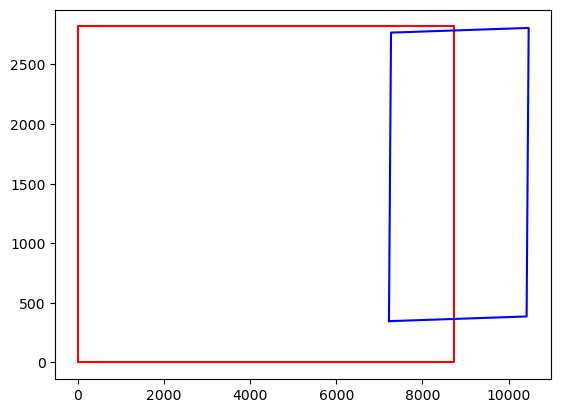

In [ ]:
fig, ax = plt.subplots()
ax.plot([0, big_img1234.shape[1], big_img1234.shape[1], 0, 0], [0, 0, big_img1234.shape[0], big_img1234.shape[0], 0], 'r-', label='reference img')
ax.plot([xdyd_r45[0][0], xdyd_r45[1][0], xdyd_r45[2][0], xdyd_r45[3][0], xdyd_r45[0][0]], [xdyd_r45[0][1], xdyd_r45[1][1], xdyd_r45[2][1], xdyd_r45[3][1], xdyd_r45[0][1]], 'b-', label='left warped img')


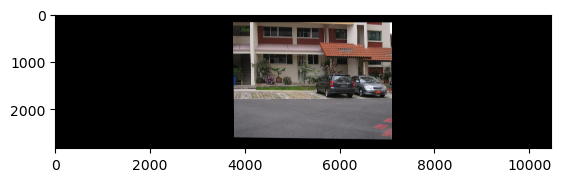

In [65]:
tmp = cv2.warpPerspective(fifth_img, best_Hr45_translated, canvas_size)
plt.imshow(cv2.cvtColor(tmp, cv2.COLOR_BGR2RGB))

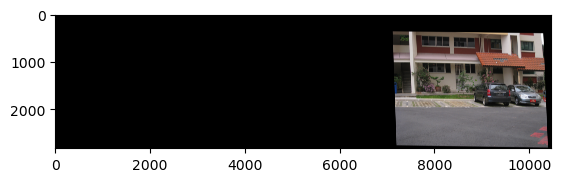

In [66]:
tmp = cv2.warpPerspective(fifth_img, best_Hr_translated @ best_Hr45_translated, canvas_size)
plt.imshow(cv2.cvtColor(tmp, cv2.COLOR_BGR2RGB))

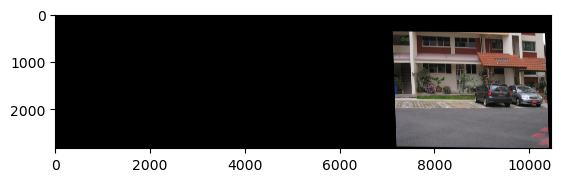

In [ ]:
big_img12345 = np.zeros((canvas_size[1], canvas_size[0], 3), dtype=np.uint8) # row1 - p1,p2,p3,p4......pn, row2 - p1,p2,p3,p4......pn, row3 - p1,p2,p3,p4......pn

best_Hr45inv = np.linalg.inv(best_Hr_translated @ best_Hr45_translated) # remember to use the translated homography matrix to accomodate the negative coordinates
# big_img12345[0 : big_img1234.shape[0], 0: big_img1234.shape[1], :] = big_img1234
for x in range(canvas_size[0]):
    for y in range(canvas_size[1]):
        dx, dy, _ = np.dot(best_Hr45inv, np.array([x, y, 1]))
        dx, dy = int(dx), int(dy)
        if dx >= 0 and dx < fifth_img.shape[1] and dy >= 0 and dy < fifth_img.shape[0]:
            big_img12345[y, x, :] = fifth_img[dy, dx, :]
            

plt.imshow(cv2.cvtColor(big_img12345, cv2.COLOR_BGR2RGB))

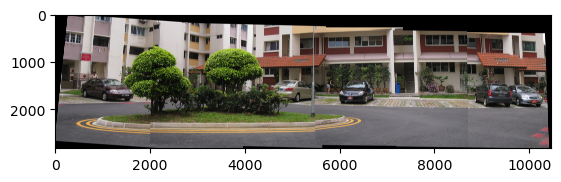

In [68]:
for y in range(big_img1234.shape[0]):
    for x in range(big_img1234.shape[1]):
        if np.all(big_img1234[y, x]) != 0 :
            big_img12345[y,x] = big_img1234[y,x]
plt.imshow(cv2.cvtColor(big_img12345, cv2.COLOR_BGR2RGB)) 

In [69]:
cv2.imwrite(f'shataxi_stitched_image_{idx}.png', big_img12345)

True

# final left image

In [70]:
first_img = cv2.imread(image_paths[idx][mid_image-3])
first_gray_img = cv2.cvtColor(first_img, cv2.COLOR_BGR2GRAY)
kp_first, des_first = sift.detectAndCompute(first_img,None)
print(len(des_first), len(des0), len(kp_first), len(kp0))

matches, mapped = matching(des_first, des0, ratio_for_matching)

best_Hl01, best_inliers = ransac(mapped, kp_first, kp0)

if best_Hl01 is not None:
    print('Homography matrix')
    print(best_Hl01)
    print(f'Number of inliers: {len(best_inliers)}')

xdyd01 = warped_coords(first_gray_img, best_Hl01)

tmp = np.concatenate([xdyd01, np.array([[0,0],[big_img12345.shape[1], 0], [big_img12345.shape[1], big_img12345.shape[0]], [0, big_img12345.shape[0]]])], axis = 0)
xmax, xmin = np.max(tmp[:,0]), np.min(tmp[:,0])
ymax, ymin = np.max(tmp[:, 1]), np.min(tmp[:,1])
offsetx = abs(int(xmin))
offsety = abs(int(ymin))
print(xmax, xmin,ymax, ymin, offsetx, offsety)
canvas_size = (int(xmax-xmin), int(ymax-ymin))
print(f'canvas_size: {canvas_size}')

20126 32500 20126 32500
Total matches before ratio test:  20126
Total matches after ratio test:  268
Homography matrix
[[ 9.80392376e-01 -2.31396670e-02 -1.96544211e+03]
 [ 8.64157542e-03  1.01590827e+00 -4.80112158e+00]
 [-1.89521229e-06  3.35745116e-06  1.00000000e+00]]
Number of inliers: 113
10466.0 -2022.0880129152245 2819.0 -4.801121581482753 2022 4
canvas_size: (12488, 2823)


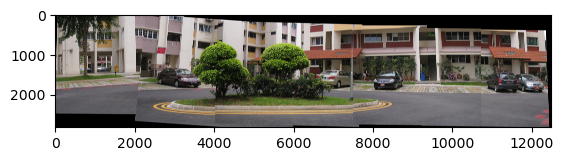

In [71]:
# translate the coordinates
best_Hl01_translated = best_Hl01.copy()
best_Hl01_translated[0][2] += offsetx
best_Hl01_translated[1][2] += offsety

# tmp = cv2.warpPerspective(second_img, best_Hl12_translated, canvas_size) # now the negative coordinates are brought into canvas
# plt.imshow(cv2.cvtColor(tmp, cv2.COLOR_BGR2RGB))

big_img012345 = np.zeros((canvas_size[1], canvas_size[0], 3), dtype=np.uint8) # row1 - p1,p2,p3,p4......pn, row2 - p1,p2,p3,p4......pn, row3 - p1,p2,p3,p4......pn
# big_img012345[0+offsety : big_img12345.shape[0]+offsety, 0+offsetx : big_img12345.shape[1]+offsetx, :] = big_img12345
best_Hl01linv = np.linalg.inv(best_Hl01_translated) # remember to use the translated homography matrix to accomodate the negative coordinates
for x in range(canvas_size[0]):
    for y in range(canvas_size[1]):
        dx, dy, _ = np.dot(best_Hl01linv, np.array([x, y, 1]))
        dx, dy = int(dx), int(dy)
        if dx >= 0 and dx < first_img.shape[1] and dy >= 0 and dy < first_img.shape[0]:
            big_img012345[y, x, :] = first_img[dy, dx, :]

for y in range(offsety, big_img12345.shape[0]+offsety):
    for x in range(offsetx, big_img12345.shape[1]+offsetx):
        if np.all(big_img12345[y-offsety, x-offsetx]) != 0 :
            big_img012345[y,x] = big_img12345[y-offsety,x-offsetx]
            
plt.imshow(cv2.cvtColor(big_img012345, cv2.COLOR_BGR2RGB))

In [73]:
cv2.imwrite(f'shataxi_stitched_image_{idx}.png', big_img012345)

True